In [1]:
# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno


# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os

import random

import warnings
from pathlib import Path, PureWindowsPath
# ignore warnings
warnings.filterwarnings('ignore')

### Using the updated pickle files to model

In [2]:
#path_to_pickle = '/Users/williamearley/Documents/GitHub/Store-Sales/data/processed/'
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_to_pickle = path_cwd / 'data'
path_to_pickle

WindowsPath('C:/Users/Cornelius/Documents/GitHub/Store-Sales/data')

In [3]:
df_train = pd.read_pickle(path_to_pickle / 'processed/df_train.pkl')
df_test = pd.read_pickle(path_to_pickle / 'processed/df_test.pkl')
df_val = pd.read_pickle(path_to_pickle / 'processed/df_val.pkl')

In [4]:
df_train['date'].max()

Timestamp('2015-04-30 00:00:00')

### Need to do some feature engineering first

On this train set we will implement dummy variables for the families

In [5]:
# One-hot encoding for family column
df_family_dummies_train = pd.get_dummies(df_train['family'], drop_first=True, prefix='family')
df_family_dummies_test = pd.get_dummies(df_test['family'], drop_first=True, prefix='family')
df_family_dummies_val = pd.get_dummies(df_val['family'], drop_first=True, prefix='family')

In [6]:
# One-hot encoding for family column, bringing dataframes together
df_train = pd.concat([df_train, df_family_dummies_train], axis=1)
df_test = pd.concat([df_test, df_family_dummies_test], axis=1)
df_val = pd.concat([df_val, df_family_dummies_val], axis=1)

In [7]:
# Replace False with 0.0 and True with 1.0
df_train.replace({False: 0.0, True: 1.0}, inplace=True)
df_test.replace({False: 0.0, True: 1.0}, inplace=True)
df_val.replace({False: 0.0, True: 1.0}, inplace=True)

In [8]:
# No longer need the original 'family' column
df_train = df_train.drop(columns=['family'])
df_test = df_test.drop(columns=['family'])
df_val = df_val.drop(columns=['family'])

In [9]:
# Set up training set
X_train = df_train.drop(columns=['sales', 'date'])
y_train = df_train['sales']

# Val set
X_val = df_val.drop(columns=['sales', 'date'])
y_val = df_val['sales']

# Test set
X_test = df_test.drop(columns=['sales', 'date'])
y_test = df_test['sales']

### Modeling

In [10]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [11]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

## XGBOOST Regressor Model

In [12]:
# Define xgboost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Fit model
model_xgb.fit(X_train, y_train)

# Predict
forecast_xgb = model_xgb.predict(X_test)

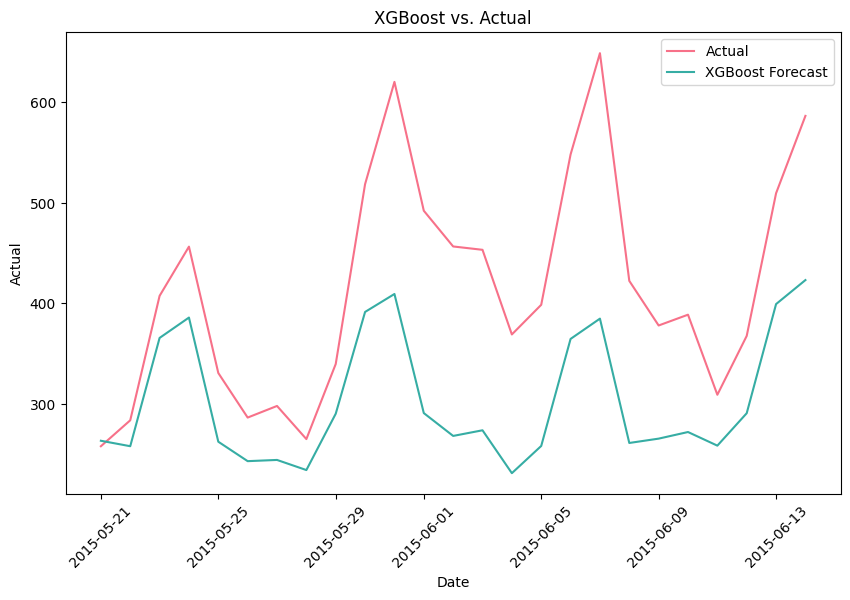

In [13]:
# Plot predictions
plot_predictions(df_test['date'], y_test, forecast_xgb, 'XGBoost Forecast', 'XGBoost vs. Actual')

In [14]:
# Metrics 
xgboost_metrics = evaluate_forecast(y_test, forecast_xgb)

xgboost_metrics

{'MSE': 362884.2780969741,
 'RMSE': 602.3987699995528,
 'RMSLE': 1.4262515856123024}

## Hyperparameter Tuning

Going to be implementing a randomized search to fine-tune our XGBoost model. 

In [15]:
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 400],
    'max_depth': [4, 6, 8]
}

# Instance of model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Perform search
random_search = RandomizedSearchCV(
    model_xgb,
    param_distributions = xgb_param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best params
best_xgb_params = random_search.best_params_

# Print out
print("Best XGBoost parameters:", best_xgb_params)

# Get best estimator
best_xgb_model = random_search.best_estimator_

# Print out
best_xgb_model

Best XGBoost parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Make a prediction with the best model
forecast_xgb_best = best_xgb_model.predict(X_test)

In [17]:
# Calculate evaluation metrics
xgb_best = evaluate_forecast(y_test, forecast_xgb_best)

xgb_best

{'MSE': 351639.15399771376,
 'RMSE': 592.9916980849848,
 'RMSLE': 1.4040005271650655}

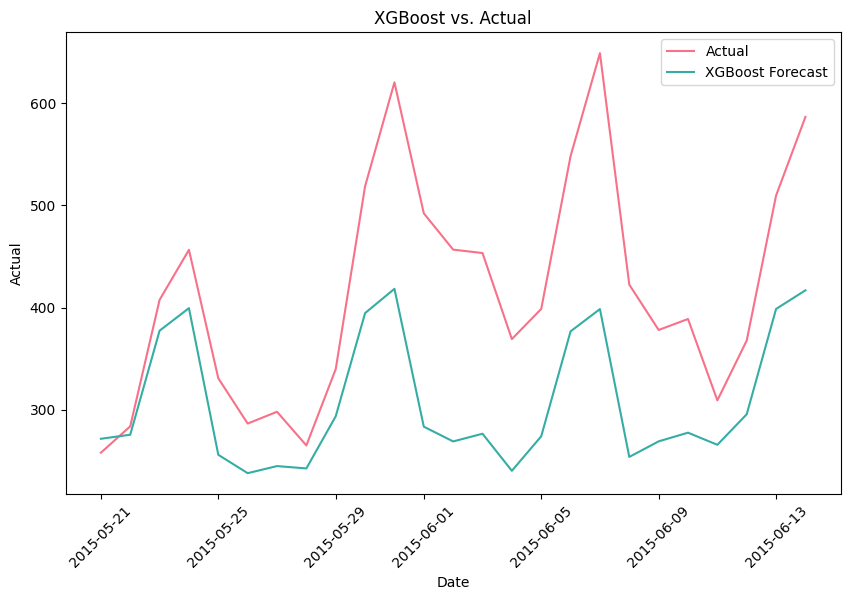

In [18]:
# Plot predictions
plot_predictions(df_test['date'], y_test, forecast_xgb_best, 'XGBoost Forecast', 'XGBoost vs. Actual')